# Multiclass DNN external performance

Evaluates all external datasets using the mulitclass DNN (that uses the xgboost features). Generates figures in figure_folder

In [11]:
figure_folder = 'multiclass_DNN_external_figs/'

Add the Evaluate module to path and make figure folder:

In [12]:
# adding this path so we can import Evaluate
import sys
import os

cwd = os.getcwd() # get the current path, and only take up to methylation-patterns-izzy (discarding the end bit)
file = 'methylation-patterns-izzy'
end = cwd.find(file) + len(file) + 1 # find start of file in path, add on its lenth to go to the end, and add on 1 to get the /
path = cwd[0:end]
print("path is ", path)
sys.path.append(path)

from Evaluate import load_and_eval
root_path = path

if not (figure_folder.strip('/') in os.listdir()):
    os.mkdir(figure_folder)

path is  /Tank/methylation-patterns-code/methylation-patterns-izzy/


Get all external datasets:

In [13]:
from get_train_and_test import get_external_data
import numpy as np

def get_big_external_set():
    big_dataset = []
    big_diagnoses = []
    cancer_types = ['BRCA', 'ESCA', 'COAD', 'PRAD', 'THCA', 'HNSC', 'KIRC', 'LIHC']
    diagnoses_nums = {'BRCA' : 2, 'ESCA': 4, 'COAD': 3, 'PRAD' : 11, 'THCA' : 12, 'HNSC' : 5, 'KIRC' : 6, 'LIHC' : 8}
    for cancer_type in cancer_types:
        
        # the ESCA folder is the (public) Australian dataset from Ganesh
        folder_dict = {'BRCA' : 'breast_cancer/', 'ESCA': 'ESCA_from_Ganesh/', 'COAD': 'colorectal carcinoma (COAD)/', 'PRAD' : 'prostate CA ICGC/', 'THCA' : 'Thyroid (THCA)/', 'HNSC' : 'Head and neck  squamous cell carcinoma (HNSC)/', 'KIRC' : 'clear cell renal cell carcinoma (KIRC)/', 'LIHC' : 'hepatocellular carcinoma (LIHC)/', 'PRAD2': 'prostate 2/', 'PRAD_meta': 'metastasis/prostate/'}
        folder_name = folder_dict[cancer_type]

        use_raw = False if cancer_type in ['THCA', 'ESCA'] else True
        use_corrected_PRAD = True if cancer_type == 'PRAD' else False
        use_training_imputation = False if cancer_type == 'ESCA' else True
        
        m_values, diagnoses = get_external_data(cancer_type, multiclass = True, remove_inf = True, has_header = False, use_raw = use_raw, root_path = '../new_data/'+folder_name, use_training_imputation = use_training_imputation, use_corrected_PRAD = use_corrected_PRAD)
        
        if big_dataset == []:
            big_dataset = m_values
        else:
            big_dataset = np.concatenate((big_dataset, m_values), axis = 0)
            
        diagnoses_changed = [diagnoses_nums[cancer_type] if d == 1 else 0 for d in diagnoses]
        big_diagnoses.extend(diagnoses_changed)
        print("Big dataset is now ", big_dataset.shape, " and big diagnoses ", len(big_diagnoses))
        
        if cancer_type == 'ESCA': # also add the OCCAMS dataset
            m_values, diagnoses = get_external_data(cancer_type, multiclass = True, remove_inf = True, has_header = False, use_raw = use_raw, root_path = '../new_data/'+folder_name, use_training_imputation = use_training_imputation, use_corrected_PRAD = use_corrected_PRAD, to_add = '_OCCAMS')
            big_dataset = np.concatenate((big_dataset, m_values), axis = 0)
            diagnoses_changed = [diagnoses_nums[cancer_type] if d == 1 else 0 for d in diagnoses]
            big_diagnoses.extend(diagnoses_changed)
            print("Big dataset is now ", big_dataset.shape, " and big diagnoses ", len(big_diagnoses))
            
    return big_dataset, big_diagnoses

big_dataset, big_diagnoses = get_big_external_set()

Using path  ../new_data/breast_cancer/m_values_from_raw_training_imputation_constant.csv
(57, 276016)
(57,)
Big dataset is now  (57, 276016)  and big diagnoses  57
Using path  ../new_data/ESCA_from_Ganesh/m_values.csv
(200, 276016)
(200,)


/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Big dataset is now  (257, 276016)  and big diagnoses  257
Using path  ../new_data/ESCA_from_Ganesh/m_values_OCCAMS.csv
(114, 276016)
(114,)
Big dataset is now  (371, 276016)  and big diagnoses  371
Using path  ../new_data/colorectal carcinoma (COAD)/m_values_from_raw_training_imputation_constant.csv
(29, 276016)
(29,)
Big dataset is now  (400, 276016)  and big diagnoses  400
Using path  ../new_data/prostate CA ICGC/m_values_from_raw_corrected_training_imputation_constant.csv
(199, 276016)
(199,)
Big dataset is now  (599, 276016)  and big diagnoses  599
Using path  ../new_data/Thyroid (THCA)/m_values_training_imputation_constant.csv
(141, 276016)
(141,)
Big dataset is now  (740, 276016)  and big diagnoses  740
Using path  ../new_data/Head and neck  squamous cell carcinoma (HNSC)/m_values_from_raw_training_imputation_constant.csv
(42, 276016)
(42,)
Big dataset is now  (782, 276016)  and big diagnoses  782
Using path  ../new_data/clear cell renal cell carcinoma (KIRC)/m_values_from_raw_tr

Extract xgboost features we are using for input:

In [14]:
# How to go from multiclass features to the found features: (from FoundFeatureNN.ipynb)

# get the important features, found by xgboost
import pandas as pd
features = pd.read_csv('../xgboost/depth3est800lr189/feature_importances/_run_1.csv', header = None) # get features found by best performing multiclass xgboost

feature_nums = [int(features[0][i].split(' ')[2]) for i in range(len(features[0]))]
len(feature_nums)

# load whole input data and pick out probes in feature_nums
big_dataset = big_dataset[:, feature_nums]
big_dataset.shape


3388

(940, 3388)

Load the DNN model:

In [15]:
from keras.models import load_model
model = load_model('../NNs/FoundFeatureNN/FeatureNN__best_model')

Evaluate:

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

/home/in268/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        name                                             values
0   Accuracy                                           0.867021
1  Precision  [0.9570815450643777, 0.0, 1.0, 0.3684210526315...
2     Recall  [0.8446969696969697, 0.0, 0.825, 0.77777777777...
3         f1  [0.89738430583501, 0.0, 0.9041095890410958, 0....
4        mcc                                           0.844068
5    roc_auc                                               None


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  2,  2,  2,  2,  9,  2,  2,  2,  9,  2,  2,  2,  2,  9,  2,  2,
        2,  2,  9,  2,  2,  2,  2,  9,  2,  2,  2,  2,  9,  2,  2,  2,  2,
        2,  9,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,
        0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4

14

            Normal  BLCA  BRCA  COAD  ESCA  HNSC  KIRC  KIRP  LIHC  LUAD  \
0.000000  0.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.000000  0.003788   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.000000  0.121212   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.000000  0.128788   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.000000  0.193182   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
0.160508       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.000000       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.000000       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.001064       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.000000       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

          LUSC  PRAD  THCA  UCEC  
0.000000   NaN   NaN   NaN   NaN  
0.000000   NaN   

/home/in268/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/in268/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


            Normal  BLCA  BRCA  COAD  ESCA  HNSC  KIRC  KIRP  LIHC  LUAD  \
1.000000  0.321951   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.996212  0.321123   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.996212  0.321516   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.996212  0.321909   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.996212  0.322304   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
0.027027       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.013514       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.000000       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NaN            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.000000       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

          LUSC  PRAD  THCA  UCEC  
1.000000   NaN   NaN   NaN   NaN  
0.996212   NaN   

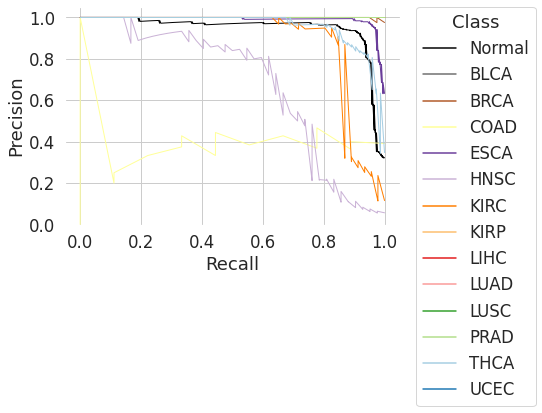

In [16]:
from Evaluate import print_evaluation

y_pred = model.predict(big_dataset, batch_size=big_dataset.shape[0])
print_evaluation(None, None, big_diagnoses, 'all_external_DNN', predictions=np.argmax(y_pred, axis=1), prob_predictions=y_pred, cm_labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13], small_text = True, save_folder=figure_folder)

confidence = model.predict_proba(big_dataset)
import numpy as np

from Evaluate import plot_curve
num_poss_classes = 14
num_poss_classes
plot_curve('roc', big_diagnoses, confidence, num_poss_classes, 'all_external_DNN', cancer_type = '', save_folder=figure_folder)
plot_curve('precision_recall', big_diagnoses, confidence, num_poss_classes, 'all_external_DNN', cancer_type = '', save_folder=figure_folder)

array([ True, False,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True, False])

In [53]:
# getting per class accuracies
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(big_diagnoses, np.argmax(y_pred, axis=1), labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13])
print(cm)

accs = []
for c in range(14):
    # code from: https://stackoverflow.com/a/65673016
    true_negs = np.sum(np.delete(np.delete(cm, c, axis=0), c, axis=1))
    true_pos = cm[c, c]
    acc = (true_negs + true_pos)/np.sum(cm)
    accs.append(acc)
accs

indices_we_care_about = np.sum(cm, axis = 1) != 0 # where there is true samples
np.array(accs)[indices_we_care_about]
# hmm these look pretty misleading...

[[223   0   0  10   9   0   1   0   0  10   0   0  11   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  33   0   0   0   0   0   0   7   0   0   0   0]
 [  0   0   0   7   0   0   0   0   0   2   0   0   0   0]
 [  5   1   0   2 192   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0  37   0   0   0   0]
 [  1   1   0   0   0   0  33   4   0   7   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  66   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   9   0 190   0   0]
 [  4   0   0   0   0   0   0   0   1   3   0   0  66   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


[0.9457446808510638,
 0.997872340425532,
 0.9925531914893617,
 0.9851063829787234,
 0.9819148936170212,
 0.9606382978723405,
 0.9851063829787234,
 0.9957446808510638,
 0.9989361702127659,
 0.9202127659574468,
 1.0,
 0.9904255319148936,
 0.9797872340425532,
 1.0]

array([0.94574468, 0.99255319, 0.98510638, 0.98191489, 0.9606383 ,
       0.98510638, 0.99893617, 0.99042553, 0.97978723])

In [54]:
indices_we_care_about

array([ True, False,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True, False])

<module 'Evaluate' from '/Tank/methylation-patterns-code/methylation-patterns-izzy/Evaluate.py'>

/home/in268/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


(940, 6)

(940, 6)

array([0.96622288, 0.99997222, 0.99212317, 0.99656757, 0.97721525,
       0.99463205])

[0.9662228796844181,
 nan,
 0.9999722222222223,
 0.9921231650554959,
 0.9965675675675676,
 nan,
 0.9772152514346854,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.9946320454403595,
 nan]

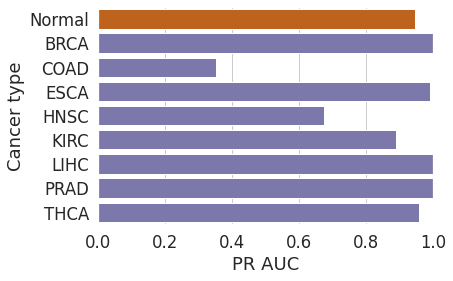

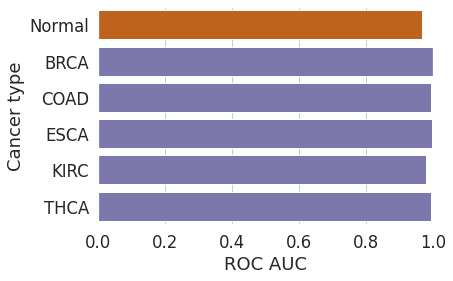

In [10]:
# getting pr and roc auc bar plots:

import importlib
import Evaluate
importlib.reload(Evaluate)

metrics_path = figure_folder + 'metrics_all_external_DNN.csv'
cancer_type = ''
model_path = '../NNs/FoundFeatureNN/FeatureNN__best_model'
from Evaluate import load_data_from_indices, get_pr_auc, plot_pr_and_roc_auc_bars


aucs = get_pr_auc('', metrics_path, model_path, big_dataset, big_diagnoses)
# aucs


# roc auc:

diagnoses_one_hot = pd.get_dummies(pd.Categorical(big_diagnoses, categories = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]))
predictions_one_hot = model.predict(big_dataset)

# removing the classes where we can't get the roc curve and classes not in external cancer types:
# these are HNSC, LIHC, and PRAD:
to_remove = ['BLCA', 'HNSC', 'LIHC', 'KIRP', 'LUAD','LUSC', 'PRAD', 'UCEC']
cancer_types = ['Normal', 'BLCA', 'BRCA', 'COAD', 'ESCA', 'HNSC', 'KIRC', 'KIRP', 'LIHC', 'LUAD', 'LUSC', 'PRAD', 'THCA', 'UCEC']

to_keep = [c for c in range(len(cancer_types)) if cancer_types[c] not in to_remove]

diagnoses_one_hot = diagnoses_one_hot.loc[:, to_keep]
predictions_one_hot = predictions_one_hot[:, to_keep]



diagnoses_one_hot.shape
predictions_one_hot.shape
from sklearn import metrics as mets

roc_auc = mets.roc_auc_score(diagnoses_one_hot, predictions_one_hot, average = None)
roc_auc

# adding back in nans to roc_auc using to_keep:
roc_aucs = []
i = 0
for c in range(len(cancer_types)):
    if c in to_keep:
        roc_aucs.append(roc_auc[i])
        i = i + 1
    else:
        roc_aucs.append(np.nan)

roc_aucs

plot_pr_and_roc_auc_bars(cancer_types, aucs, None, roc_aucs, pr_save_path = figure_folder + 'PR_bar_plot_xgboost_multiclass_external.svg', roc_save_path = figure_folder + 'ROC_bar_plot_xgboost_multiclass_external.svg')




In [9]:
cancer_types

['Normal',
 'BLCA',
 'BRCA',
 'COAD',
 'ESCA',
 'HNSC',
 'KIRC',
 'KIRP',
 'LIHC',
 'LUAD',
 'LUSC',
 'PRAD',
 'THCA',
 'UCEC']